# Amazon SageMaker Debugger - Using built-in rule
[Amazon SageMaker](https://aws.amazon.com/sagemaker/) is managed platform to build, train and host maching learning models. Amazon SageMaker Debugger is a new feature which offers the capability to debug machine learning models during training by identifying and detecting problems with the models in near real-time. 

In this notebook you'll be looking at how to use a SageMaker provided built in rule during a TensorFlow training job.

## How does Amazon SageMaker Debugger work?

Amazon SageMaker Debugger lets you go beyond just looking at scalars like losses and accuracies during training and gives you full visibility into all tensors 'flowing through the graph' during training. Furthermore, it helps you monitor your training in near real-time using rules and provides you alerts, once it has detected inconsistency in training flow.

### Concepts
* **Tensors**: These represent the state of the training network at intermediate points during its execution
* **Debug Hook**: Hook is the construct with which Amazon SageMaker Debugger looks into the training process and captures the tensors requested at the desired step intervals
* **Rule**: A logical construct, implemented as Python code, which helps analyze the tensors captured by the hook and report anomalies, if at all

With these concepts in mind, let's understand the overall flow of things that Amazon SageMaker Debugger uses to orchestrate debugging

### Saving tensors during training

The tensors captured by the debug hook are stored in the S3 location specified by you. There are two ways you can configure Amazon SageMaker Debugger to save tensors:

#### With no changes to your training script
If you use one of Amazon SageMaker provided [Deep Learning Containers](https://docs.aws.amazon.com/sagemaker/latest/dg/pre-built-containers-frameworks-deep-learning.html) for 1.15, then you don't need to make any changes to your training script for the tensors to be stored. Amazon SageMaker Debugger will use the configuration you provide through Amazon SageMaker SDK's Tensorflow `Estimator` when creating your job to save the tensors in the fashion you specify. You can review the script we are going to use at [src/mnist_zerocodechange.py](src/mnist_zerocodechange.py). You will note that this is an untouched TensorFlow script which uses the `tf.estimator` interface. Please note that Amazon SageMaker Debugger only supports `tf.keras`, `tf.Estimator` and `tf.MonitoredSession` interfaces. Full description of support is available at [Amazon SageMaker Debugger with TensorFlow ](https://github.com/awslabs/sagemaker-debugger/tree/master/docs/tensorflow.md)

#### Orchestrating your script to store tensors
For other containers, you need to make couple of lines of changes to your training script. The Amazon SageMaker Debugger exposes a library `smdebug` which allows you to capture these tensors and save them for analysis. It's highly customizable and allows to save the specific tensors you want at different frequencies and possibly with other configurations. Refer [DeveloperGuide](https://github.com/awslabs/sagemaker-debugger/tree/master/docs) for details on how to use the Debugger library with your choice of framework in your training script. Here we have an example script orchestrated at [src/mnist_byoc](src/mnist_byoc.py). You also need to ensure that your container has the `smdebug` library installed.

### Analysis of tensors

Once the tensors are saved, Amazon SageMaker Debugger can be configured to run debugging ***Rules*** on them. At a very broad level, a rule is python code used to detect certain conditions during training. Some of the conditions that a data scientist training an algorithm may care about are monitoring for gradients getting too large or too small, detecting overfitting, and so on. Amazon Sagemaker Debugger will come pre-packaged with certain first-party (1P) rules. Users can write their own rules using Amazon Sagemaker Debugger APIs. You can also analyze raw tensor data outside of the Rules construct in say, a Sagemaker notebook, using Amazon Sagemaker Debugger's full set of APIs. This notebook will show you how to use a built in SageMaker Rule with your training job as well as provide a sneak peak into these APIs for interactive exploration. Please refer [Analysis Developer Guide](https://github.com/awslabs/sagemaker-debugger/blob/master/docs/api.md) for more on these APIs.

## Setup

Follow this one time setup to get your notebook up and running to use Amazon SageMaker Debugger. This is only needed because we plan to perform interactive analysis using this library in the notebook. 

In [1]:
! pip install smdebug

With the setup out of the way let's start training our TensorFlow model in SageMaker with the debugger enabled.

## Training TensorFlow models in SageMaker with Amazon SageMaker Debugger

### SageMaker TensorFlow as a framework

We'll train a TensorFlow model in this notebook with Amazon Sagemaker Debugger enabled and monitor the training jobs with Amazon Sagemaker Debugger Rules. This will be done using Amazon SageMaker [TensorFlow 1.15.0](https://docs.aws.amazon.com/sagemaker/latest/dg/pre-built-containers-frameworks-deep-learning.html) Container as a framework.


In [2]:
import boto3
import os
import sagemaker
from sagemaker.tensorflow import TensorFlow

Let's import the libraries needed for our demo of Amazon SageMaker Debugger.

In [3]:
from sagemaker.debugger import (
    Rule,
    DebuggerHookConfig,
    TensorBoardOutputConfig,
    CollectionConfig,
    rule_configs,
)

Now we'll define the configuration for our training to run. We'll using image recognition using MNIST dataset as our training example.

In [4]:
# define the entrypoint script
entrypoint_script = "src/mnist_zerocodechange.py"

hyperparameters = {"num_epochs": 3}

### Setting up the Estimator

Now it's time to setup our TensorFlow estimator. We've added new parameters to the estimator to enable your training job for debugging through Amazon SageMaker Debugger. These new parameters are explained below.

* **debugger_hook_config**: This new parameter accepts a local path where you wish your tensors to be written to and also accepts the S3 URI where you wish your tensors to be uploaded to. SageMaker will take care of uploading these tensors transparently during execution.
* **rules**: This new parameter will accept a list of rules you wish to evaluate against the tensors output by this training job. For rules, Amazon SageMaker Debugger supports two types:
 * **SageMaker Rules**: These are rules specially curated by the data science and engineering teams in Amazon SageMaker which you can opt to evaluate against your training job.
 * **Custom Rules**: You can optionally choose to write your own rule as a Python source file and have it evaluated against your training job. To provide Amazon SageMaker Debugger to evaluate this rule, you would have to provide the S3 location of the rule source and the evaluator image.
 
#### Using Amazon SageMaker Rules
 
In this example we'll demonstrate how to use SageMaker rules to be evaluated against your training. You can find the list of SageMaker rules and the configurations best suited for using them [here](https://github.com/awslabs/sagemaker-debugger-rulesconfig).

The rules we'll use are **VanishingGradient** and **LossNotDecreasing**. As the names suggest, the rules will attempt to evaluate if there are vanishing gradients in the tensors captured by the debugging hook during training and also if the loss is not decreasing.

In [5]:
rules = [
    Rule.sagemaker(rule_configs.vanishing_gradient()),
    Rule.sagemaker(rule_configs.loss_not_decreasing()),
]

estimator = TensorFlow(
    role=sagemaker.get_execution_role(),
    base_job_name="smdebugger-demo-mnist-tensorflow",
    train_instance_count=1,
    train_instance_type="ml.m4.xlarge",
    train_volume_size=400,
    entry_point=entrypoint_script,
    framework_version="1.15",
    py_version="py3",
    train_max_run=3600,
    script_mode=True,
    hyperparameters=hyperparameters,
    ## New parameter
    rules=rules,
)

*Note that Amazon Sagemaker Debugger is only supported for py_version='py3' currently.*

Let's start the training by calling `fit()` on the TensorFlow estimator.

In [6]:
estimator.fit(wait=True)

2020-04-27 23:56:40 Starting - Starting the training job...
2020-04-27 23:57:04 Starting - Launching requested ML instances
********* Debugger Rule Status *********
*
*  VanishingGradient: InProgress        
*  LossNotDecreasing: InProgress        
*
****************************************
...
2020-04-27 23:57:36 Starting - Preparing the instances for training.........
2020-04-27 23:59:10 Downloading - Downloading input data
2020-04-27 23:59:10 Training - Downloading the training image...
2020-04-27 23:59:30 Training - Training image download completed. Training in progress..WARNING:tensorflow:From /usr/local/lib/python3.6/dist-packages/tensorflow_core/__init__.py:1473: The name tf.estimator.inputs is deprecated. Please use tf.compat.v1.estimator.inputs instead.

2020-04-27 23:59:36,257 sagemaker-containers INFO     Imported framework sagemaker_tensorflow_container.training
2020-04-27 23:59:36,263 sagemaker-containers INFO     No GPUs detected (normal if no gpus installed)
2020-04-27 

## Result 

As a result of calling the `fit()` Amazon SageMaker Debugger kicked off two rule evaluation jobs to monitor vanishing gradient and loss decrease, in parallel with the training job. The rule evaluation status(es) will be visible in the training logs at regular intervals. As you can see, in the summary, there was no step in the training which reported vanishing gradients in the tensors. Although, the loss was not found to be decreasing at step 1900.

In [8]:
estimator.latest_training_job.rule_job_summary()

[{'RuleConfigurationName': 'VanishingGradient',
  'RuleEvaluationJobArn': 'arn:aws:sagemaker:us-east-2:441510144314:processing-job/smdebugger-demo-mnist-tens-vanishinggradient-5268f8d7',
  'RuleEvaluationStatus': 'NoIssuesFound',
  'LastModifiedTime': datetime.datetime(2020, 4, 28, 0, 3, 10, 18000, tzinfo=tzlocal())},
 {'RuleConfigurationName': 'LossNotDecreasing',
  'RuleEvaluationJobArn': 'arn:aws:sagemaker:us-east-2:441510144314:processing-job/smdebugger-demo-mnist-tens-lossnotdecreasing-5793ad60',
  'RuleEvaluationStatus': 'NoIssuesFound',
  'LastModifiedTime': datetime.datetime(2020, 4, 28, 0, 3, 10, 18000, tzinfo=tzlocal())}]

Let's try and look at the logs of the rule job for loss not decreasing. To do that, we'll use this utlity function to get a link to the rule job logs.

In [9]:
def _get_rule_job_name(training_job_name, rule_configuration_name, rule_job_arn):
    """Helper function to get the rule job name with correct casing"""
    return "{}-{}-{}".format(
        training_job_name[:26], rule_configuration_name[:26], rule_job_arn[-8:]
    )


def _get_cw_url_for_rule_job(rule_job_name, region):
    return "https://{}.console.aws.amazon.com/cloudwatch/home?region={}#logStream:group=/aws/sagemaker/ProcessingJobs;prefix={};streamFilter=typeLogStreamPrefix".format(
        region, region, rule_job_name
    )


def get_rule_jobs_cw_urls(estimator):
    region = boto3.Session().region_name
    training_job = estimator.latest_training_job
    training_job_name = training_job.describe()["TrainingJobName"]
    rule_eval_statuses = training_job.describe()["DebugRuleEvaluationStatuses"]

    result = {}
    for status in rule_eval_statuses:
        if status.get("RuleEvaluationJobArn", None) is not None:
            rule_job_name = _get_rule_job_name(
                training_job_name, status["RuleConfigurationName"], status["RuleEvaluationJobArn"]
            )
            result[status["RuleConfigurationName"]] = _get_cw_url_for_rule_job(
                rule_job_name, region
            )
    return result


get_rule_jobs_cw_urls(estimator)

{'VanishingGradient': 'https://us-east-2.console.aws.amazon.com/cloudwatch/home?region=us-east-2#logStream:group=/aws/sagemaker/ProcessingJobs;prefix=smdebugger-demo-mnist-tens-VanishingGradient-5268f8d7;streamFilter=typeLogStreamPrefix',
 'LossNotDecreasing': 'https://us-east-2.console.aws.amazon.com/cloudwatch/home?region=us-east-2#logStream:group=/aws/sagemaker/ProcessingJobs;prefix=smdebugger-demo-mnist-tens-LossNotDecreasing-5793ad60;streamFilter=typeLogStreamPrefix'}

## Data Analysis - Interactive Exploration
Now that we have trained a job, and looked at automated analysis through rules, let us also look at another aspect of Amazon SageMaker Debugger. It allows us to perform interactive exploration of the tensors saved in real time or after the job. Here we focus on after-the-fact analysis of the above job. We import the `smdebug` library, which defines a concept of Trial that represents a single training run. Note how we fetch the path to debugger artifacts for the above job.

In [10]:
from smdebug.trials import create_trial

trial = create_trial(estimator.latest_job_debugger_artifacts_path())

[2020-04-28 00:07:09.068 f8455ab5c5ab:546 INFO s3_trial.py:42] Loading trial debug-output at path s3://sagemaker-us-east-2-441510144314/smdebugger-demo-mnist-tensorflow-2020-04-27-23-56-39-900/debug-output


We can list all the tensors that were recorded to know what we want to plot. Each one of these names is the name of a tensor, which is auto-assigned by TensorFlow. In some frameworks where such names are not available, we try to create a name based on the layer's name and whether it is weight, bias, gradient, input or output.

In [11]:
trial.tensor_names()

[2020-04-28 00:07:11.217 f8455ab5c5ab:546 INFO trial.py:198] Training has ended, will refresh one final time in 1 sec.
[2020-04-28 00:07:12.236 f8455ab5c5ab:546 INFO trial.py:210] Loaded all steps


['gradients/conv2d/BiasAdd_grad/tuple/control_dependency_1:0',
 'gradients/conv2d/Conv2D_grad/tuple/control_dependency_1:0',
 'gradients/conv2d_1/BiasAdd_grad/tuple/control_dependency_1:0',
 'gradients/conv2d_1/Conv2D_grad/tuple/control_dependency_1:0',
 'gradients/dense/BiasAdd_grad/tuple/control_dependency_1:0',
 'gradients/dense/MatMul_grad/tuple/control_dependency_1:0',
 'gradients/dense_1/BiasAdd_grad/tuple/control_dependency_1:0',
 'gradients/dense_1/MatMul_grad/tuple/control_dependency_1:0',
 'sparse_softmax_cross_entropy_loss/value:0']

We can also retrieve tensors by some default collections that `smdebug` creates from your training job. Here we are interested in the losses collection, so we can retrieve the names of tensors in losses collection as follows. Amazon SageMaker Debugger creates default collections such as weights, gradients, biases, losses automatically. You can also create custom collections from your tensors.

In [12]:
trial.tensor_names(collection="losses")

['sparse_softmax_cross_entropy_loss/value:0']

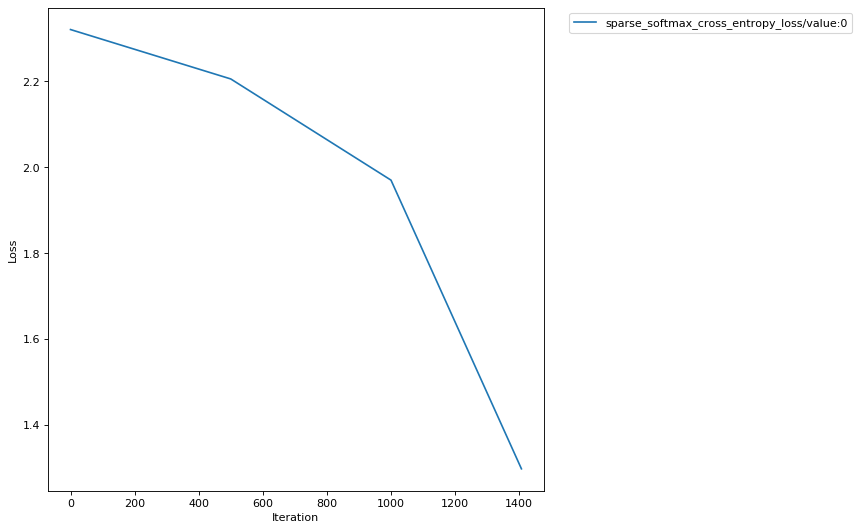

In [13]:
import matplotlib.pyplot as plt
import re

# Define a function that, for the given tensor name, walks through all
# the iterations for which we have data and fetches the value.
# Returns the set of steps and the values
def get_data(trial, tname):
    tensor = trial.tensor(tname)
    steps = tensor.steps()
    vals = [tensor.value(s) for s in steps]
    return steps, vals


def plot_tensors(trial, collection_name, ylabel=""):
    """
    Takes a `trial` and plots all tensors that match the given regex.
    """
    plt.figure(num=1, figsize=(8, 8), dpi=80, facecolor="w", edgecolor="k")

    tensors = trial.tensor_names(collection=collection_name)

    for tensor_name in sorted(tensors):
        steps, data = get_data(trial, tensor_name)
        plt.plot(steps, data, label=tensor_name)

    plt.legend(bbox_to_anchor=(1.04, 1), loc="upper left")
    plt.xlabel("Iteration")
    plt.ylabel(ylabel)
    plt.show()


plot_tensors(trial, "losses", ylabel="Loss")